In [86]:
import json
from nltk.tokenize import word_tokenize
import nltk
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [87]:
# 1. Setup
nltk.download('punkt')

# 2. Load file JSON
file_path = r"D:\Kumara\Stemming-vs-Lemmatization-on-LDA-Topic-Modelling\data\cleaned\cleaned_abstracts_lemmatization.json"

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [88]:
# 3. Tokenisasi teks
texts = [word_tokenize(doc["cleaned_abstract"]) for doc in data]

# 4. Buat dictionary dan corpus BoW
dictionary = corpora.Dictionary(texts)
bow_corpus = [dictionary.doc2bow(text) for text in texts]

In [89]:
# Tampilkan hasil tokenisasi
for i, tokens in enumerate(texts):
    print(f"Abstrak {i+1}: {tokens}")

Abstrak 1: ['technical', 'progress', 'open', 'source', 'self', 'replicate', 'rapid', 'prototyper', 'reprap', 'community', 'enable', 'distribute', 'form', 'additive', 'manufacturing', 'expand', 'rapidly', 'use', 'polymer', 'base', 'material', 'however', 'lack', 'open', 'source', 'metal', 'alternative', 'high', 'capital', 'cost', 'slow', 'throughput', 'proprietary', 'commercialize', 'metal', 'printer', 'severely', 'restrict', 'deployment', 'application', 'commercialize', 'metal', 'printer', 'limit', 'rapid', 'prototyping', 'expensive', 'finished', 'product', 'severely', 'restrict', 'access', 'technology', 'small', 'medium', 'enterprise', 'develop', 'world', 'use', 'laboratory', 'paper', 'report', 'development', 'source', 'metal', 'printer', 'metal', 'printer', 'control', 'open', 'source', 'micro', 'controller', 'combination', 'low', 'cost', 'commercial', 'gas', 'metal', 'arc', 'welder', 'derivative', 'rostock', 'deltabot', 'reprap', 'bill', 'material', 'electrical', 'mechanical', 'design

In [90]:
lda_model = LdaModel(corpus=bow_corpus,
                           id2word=dictionary,
                           num_topics=3,
                           random_state=42,
                           passes=10,
                           alpha='auto',
                           per_word_topics=True)

In [91]:
results = []

for i, bow in enumerate(bow_corpus):
    topic_dist = lda_model.get_document_topics(bow)
    top_topic_id, top_prob = max(topic_dist, key=lambda x: x[1])
    
    topic_keywords = lda_model.show_topic(top_topic_id, topn=5)
    keywords = [word for word, prob in topic_keywords]

    result = {
        "abstrak_ke": i + 1,
        "topik_dominan": top_topic_id,
        "proporsi": round(top_prob, 4),
        "kata_kunci": keywords
    }
    
    results.append(result)

    print(f"Abstrak {i+1}: Topik dominan #{top_topic_id} dengan proporsi {top_prob:.4f}")
    print(f"  Kata kunci topik: {', '.join(keywords)}\n")

Abstrak 1: Topik dominan #1 dengan proporsi 0.9995
  Kata kunci topik: system, use, link, traceability, study

Abstrak 2: Topik dominan #1 dengan proporsi 0.9996
  Kata kunci topik: system, use, link, traceability, study

Abstrak 3: Topik dominan #0 dengan proporsi 0.9994
  Kata kunci topik: propose, datum, use, method, algorithm

Abstrak 4: Topik dominan #2 dengan proporsi 0.9996
  Kata kunci topik: network, smart, model, system, accuracy

Abstrak 5: Topik dominan #1 dengan proporsi 0.9996
  Kata kunci topik: system, use, link, traceability, study

Abstrak 6: Topik dominan #1 dengan proporsi 0.9996
  Kata kunci topik: system, use, link, traceability, study

Abstrak 7: Topik dominan #0 dengan proporsi 0.9997
  Kata kunci topik: propose, datum, use, method, algorithm

Abstrak 8: Topik dominan #2 dengan proporsi 0.9993
  Kata kunci topik: network, smart, model, system, accuracy

Abstrak 9: Topik dominan #1 dengan proporsi 0.9994
  Kata kunci topik: system, use, link, traceability, study


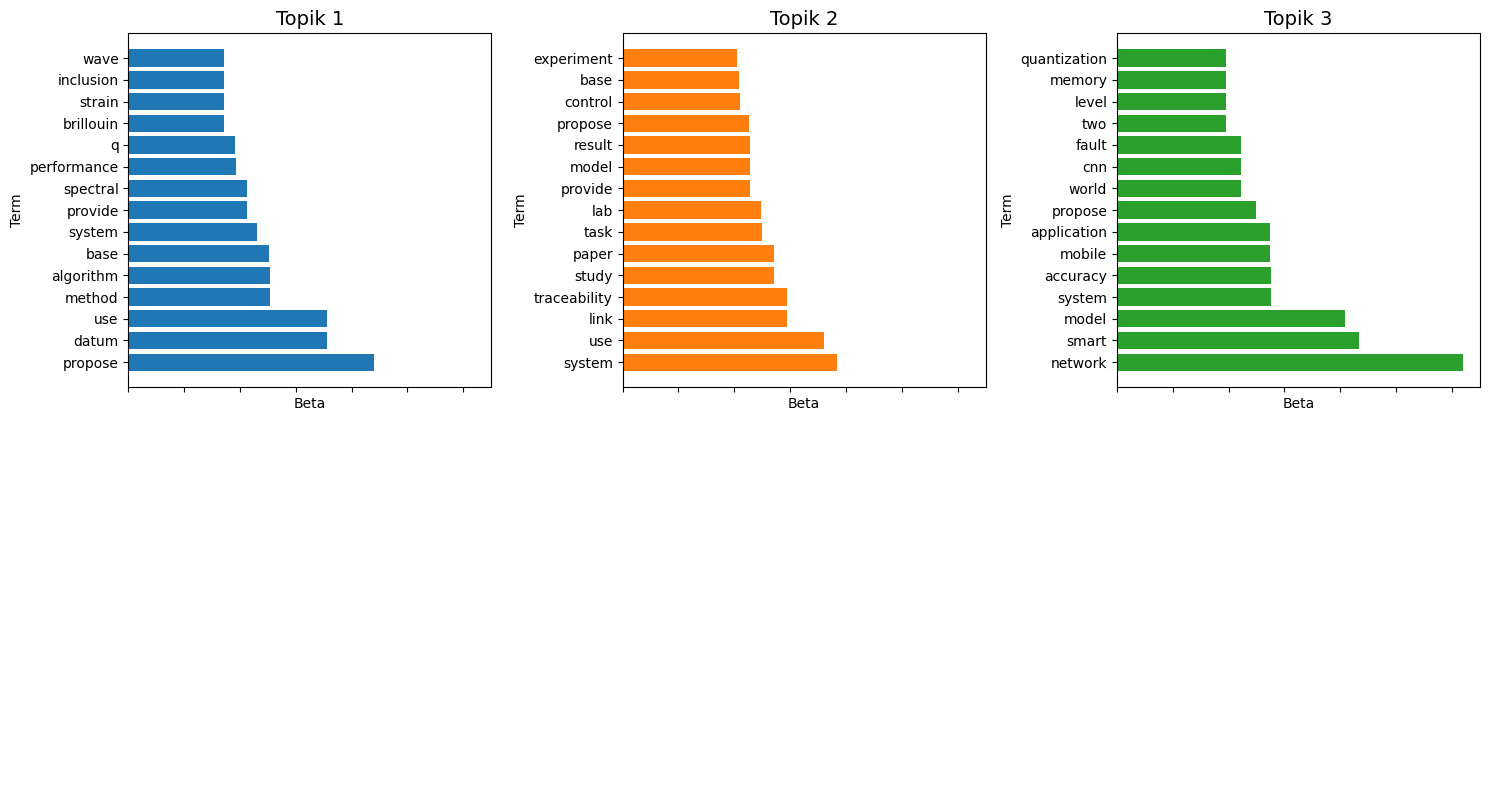

In [92]:
num_topics = lda_model.num_topics
topn = 15

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True) 
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= num_topics:
        ax.axis('off')
        continue
    
    topic = lda_model.show_topic(i, topn=topn)
    words = [word for word, prob in topic]
    probs = [prob for word, prob in topic]
    
    ax.barh(words[::-1], probs[::-1], color=plt.cm.tab10(i))
    ax.set_title(f'Topik {i+1}', fontsize=14)
    ax.set_xlabel('Beta')
    ax.set_ylabel('Term')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [93]:
for i in range(lda_model.num_topics):
    print(f"Topik {i}:")
    print(lda_model.show_topic(i, topn=10))


Topik 0:
[('propose', 0.011004381), ('datum', 0.008895827), ('use', 0.008882766), ('method', 0.0063568787), ('algorithm', 0.00635642), ('base', 0.006308939), ('system', 0.0057748035), ('provide', 0.005320866), ('spectral', 0.0053129992), ('performance', 0.004806679)]
Topik 1:
[('system', 0.009611298), ('use', 0.009039461), ('link', 0.0073437877), ('traceability', 0.007340252), ('study', 0.0067853592), ('paper', 0.0067801108), ('task', 0.006231504), ('lab', 0.006198442), ('provide', 0.0056942147), ('model', 0.005684273)]
Topik 2:
[('network', 0.015488737), ('smart', 0.010841787), ('model', 0.010201494), ('system', 0.00689757), ('accuracy', 0.0068830876), ('mobile', 0.006840023), ('application', 0.0068342327), ('propose', 0.006236239), ('world', 0.005544403), ('cnn', 0.0055435197)]


In [94]:
coherence_model_lda = CoherenceModel(
    model=lda_model, 
    texts=texts, 
    dictionary=dictionary, 
    coherence='c_v'
)

coherence_score = coherence_model_lda.get_coherence()
print(f"\nCoherence Score (BoW): {coherence_score:.4f}")


Coherence Score (BoW): 0.3789
